In [ ]:
# !pip install tensorflow-model-optimization
# !pip install tensorflowjs

In [1]:
#Import Library yang di butuhkan
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.metrics import classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ini udah pakai data yang baru, size 150 * 150
train_dir = '/content/drive/MyDrive/Bangkit/WOWRACK/dataset/Sampah/TrainV2'
val_dir = '/content/drive/MyDrive/Bangkit/WOWRACK/dataset/Sampah/ValV2'
test_dir = '/content/drive/MyDrive/Bangkit/WOWRACK/dataset/Sampah/TestV2'
typedat = ['kosong', 'penuh']

for i in typedat:
    class_dir = os.path.join(train_dir, i)
    file_count = len([file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))])
    print("Jumlah file dalam folder train kelas", i, ":", file_count)

for i in typedat:
    class_dir = os.path.join(val_dir, i)
    file_count = len([file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))])
    print("Jumlah file dalam folder val kelas", i, ":", file_count)

for i in typedat:
    class_dir = os.path.join(test_dir, i)
    file_count = len([file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))])
    print("Jumlah file dalam folder val kelas", i, ":", file_count)

Jumlah file dalam folder train kelas kosong : 1554
Jumlah file dalam folder train kelas penuh : 1554
Jumlah file dalam folder val kelas kosong : 444
Jumlah file dalam folder val kelas penuh : 444
Jumlah file dalam folder val kelas kosong : 222
Jumlah file dalam folder val kelas penuh : 222


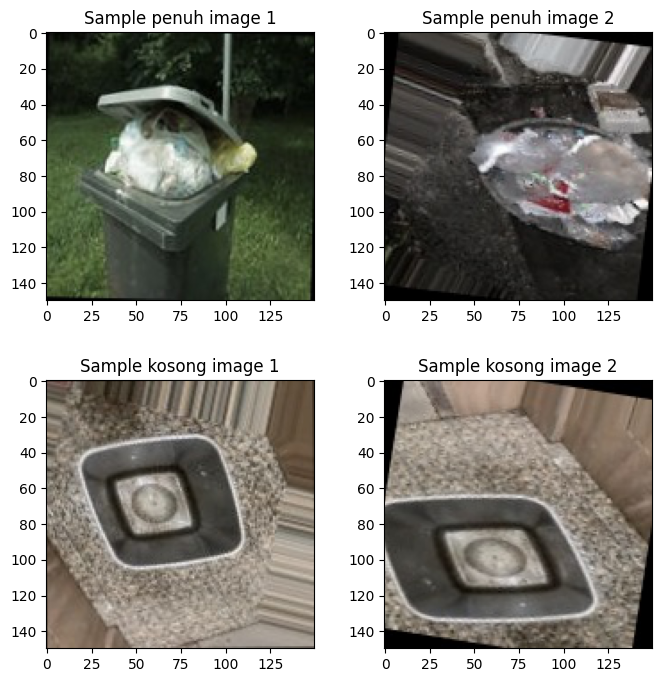

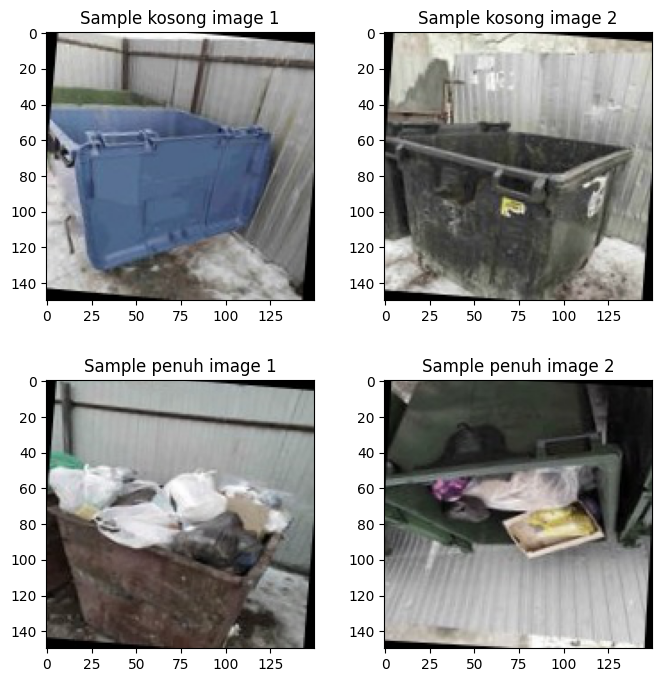

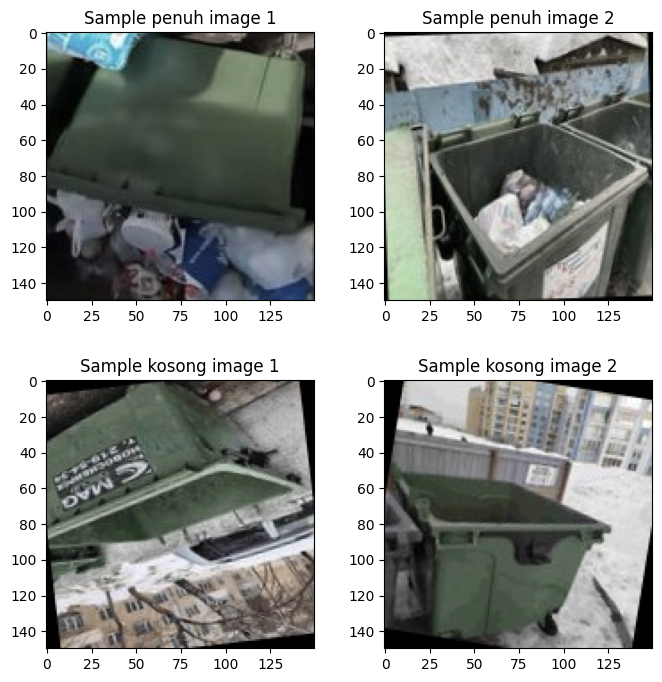

In [4]:
def display_sample_image(folder_path):
    classes = os.listdir(folder_path)
    fig, axs = plt.subplots(nrows=len(classes), ncols=2, figsize=(8, 4*len(classes)))
    fig.subplots_adjust(hspace=0.3)

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            sample_image_paths = [os.path.join(class_dir, file_name) for file_name in os.listdir(class_dir)[:2]]
            for j, sample_image_path in enumerate(sample_image_paths):
                sample_image = Image.open(sample_image_path)
                resized_image = sample_image.resize((150, 150))
                axs[i, j].imshow(resized_image)
                axs[i, j].set_title(f"Sample {class_name} image {j+1}")

    plt.show()

display_sample_image(train_dir)
display_sample_image(val_dir)
display_sample_image(test_dir)

In [6]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True
    )
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=32,
        class_mode='binary',
        target_size=(150, 150)
    )

    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        class_mode='binary',
        target_size=(150, 150)
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(
        directory=TEST_DIR,
        batch_size=32,
        class_mode='binary',
        target_size=(150, 150)
    )

    return train_generator, validation_generator, test_generator


In [7]:
train_generator, validation_generator, test_generator = train_val_generators(train_dir, val_dir, test_dir)

Found 3108 images belonging to 2 classes.
Found 888 images belonging to 2 classes.
Found 444 images belonging to 2 classes.


## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-07 14:24:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   248MB/s    in 0.3s    

2023-06-07 14:24:18 (248 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
      layer.trainable = False

  ### END CODE HERE

  return pre_trained_model

In [11]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [12]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [13]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0006, beta_1=0.9, beta_2=0.999, amsgrad=True)
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model
  
  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model
    
  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  # x = layers.Dense(128, activation = 'relu')(x)
  # # Add a dropout rate of 0.2
  # x = layers.Dense(128, activation = 'relu')(x)
  # x = layers.Dense(512, activation = 'relu')(x)
  x = layers.Dense(1024, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation = 'sigmoid')(x)       
 
  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = optimizer, 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  
  return model

In [19]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [20]:
callbacks = myCallback()
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=50, validation_data=validation_generator, callbacks = callbacks)

Epoch 1/50
98/98 [==============================] - 476s 5s/step - loss: 0.3117 - accuracy: 0.9003 - val_loss: 0.1068 - val_accuracy: 0.9628
Epoch 2/50
98/98 [==============================] - 27s 274ms/step - loss: 0.1559 - accuracy: 0.9353 - val_loss: 0.0713 - val_accuracy: 0.9775
Epoch 3/50
98/98 [==============================] - 27s 274ms/step - loss: 0.1155 - accuracy: 0.9553 - val_loss: 0.0591 - val_accuracy: 0.9752
Epoch 4/50
98/98 [==============================] - 27s 275ms/step - loss: 0.1020 - accuracy: 0.9579 - val_loss: 0.0717 - val_accuracy: 0.9741
Epoch 5/50
98/98 [==============================] - 27s 275ms/step - loss: 0.1063 - accuracy: 0.9566 - val_loss: 0.0882 - val_accuracy: 0.9707
Epoch 6/50
98/98 [==============================] - 27s 276ms/step - loss: 0.0950 - accuracy: 0.9627 - val_loss: 0.0878 - val_accuracy: 0.9707
Epoch 7/50
98/98 [==============================] - 27s 274ms/step - loss: 0.0796 - accuracy: 0.9691 - val_loss: 0.0407 - val_accuracy: 0.9854
E

In [21]:
epoch_avg_acc = sum(history.history['accuracy']) / len(history.history['accuracy'])
print("Epoch average accuracy: {:.2f}%".format(epoch_avg_acc * 100))

Epoch average accuracy: 98.09%


In [22]:
epoch_avg_acc = sum(history.history['loss']) / len(history.history['loss'])
print("Epoch average loss: {:.2f}%".format(epoch_avg_acc * 100))

Epoch average loss: 5.03%


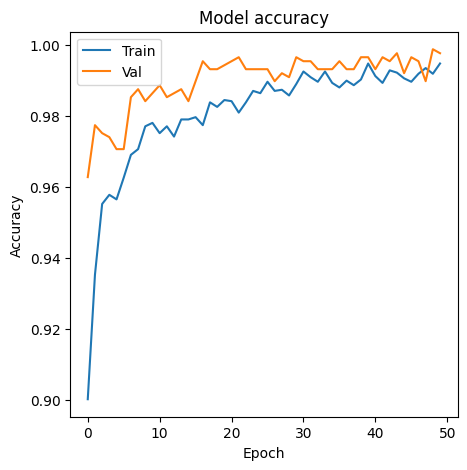

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

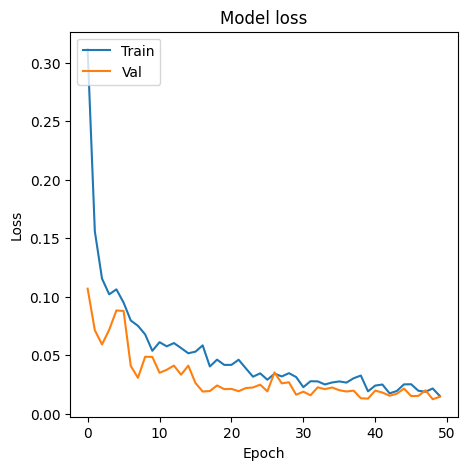

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [25]:
y_pred = model.predict(test_generator)

14/14 [==============================] - 137s 10s/step


In [26]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("test loss:",test_loss)
print("test acc:",test_accuracy)

14/14 [==============================] - 1s 83ms/step - loss: 0.0051 - accuracy: 0.9977
test loss: 0.005088035482913256
test acc: 0.9977477192878723


In [27]:
import numpy as np

In [28]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(y_pred, axis=1)

In [29]:
target_names = ['Class 1', 'Class 2']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.50      1.00      0.67       222
     Class 2       0.00      0.00      0.00       222

    accuracy                           0.50       444
   macro avg       0.25      0.50      0.33       444
weighted avg       0.25      0.50      0.33       444



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[222,   0],
       [222,   0]])

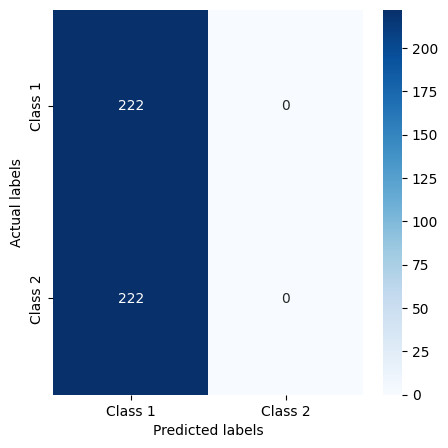

In [31]:
# Create heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.show()

In [32]:
saved_model_path = "/content/drive/MyDrive/Bangkit/WOWRACK/Datasets_Model_Sampah/trashsigmoid.h5"
model.save(saved_model_path)

Saving _5_335368.png to _5_335368.png


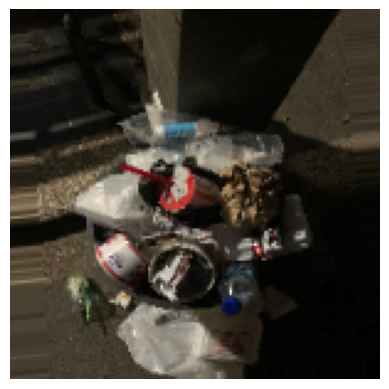

1/1 [==============================] - 1s 847ms/step
[[1.]]
penuh


In [36]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

uploaded = files.upload()

# Definisikan path ke file model
#model_path = '/content/drive/MyDrive/Bangkit/WOWRACK/Datasets_Model_Sampah/trash.h5'

# Buat fungsi untuk memuat model
def load_model(model_path):
    # Muat model dari file h5
    model = tf.keras.models.load_model(model_path)
    return model

# Panggil fungsi untuk memuat model
model = load_model(saved_model_path)

for fn in uploaded.keys():

    # predicting images
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Mengubah gambar menjadi format yang dapat diprediksi oleh model
    img = image.load_img(fn, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Melakukan normalisasi gambar

    # Melakukan prediksi menggunakan model
    prediction = model.predict(x)
    print(prediction)
    if prediction[0][0] < 0.5:
        print('Sampah Kosong')
    else:
        print('penuh')


### Mencoba untuk menggunakan activation Sigmoid

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Load the saved model
model = tf.keras.models.load_model(saved_model_path)

# Convert the model to a TensorFlow ConcreteFunction
converter = tf.lite.TFLiteConverter.from_keras_model(model)
concrete_func = converter.convert()

# Apply quantization-aware training to the model
quantized_model = tfmot.quantization.keras.quantize_model(model)
quantized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the quantized model...

# Save the quantized model
quantized_model.save('quantized_model.h5')

### Try to add pretrained model
### Memakai Efficeintent

In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2M
base_model = EfficientNetV2M(include_top = False, weights='imagenet', input_shape=(150, 150, 3))
base_model.summary()

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0006, beta_1=0.9, beta_2=0.999, amsgrad=True)
model_new.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

callbacks = myCallback()
history = model_new.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=100, validation_data=validation_generator, callbacks = callbacks)

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()